## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [4]:
import os
import keras
import tensorflow
from keras.datasets import cifar10

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [8]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [9]:

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras import regularizers

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, 
              output_units=10, 
              num_neurons=[512, 256, 128], 
              use_bn=True,
              drp_ratio=0,
              l2_ratio=0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = BatchNormalization()(x)                
        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = BatchNormalization()(x)                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
"""Code Here
設定超參數
"""
'''
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95
PRE_ACTIVATE = [True, False]
'''
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 128

USE_BN = [True, False]
DRP_RATIO = [0., 0.4, 0.8]
L2_RATIO = [0, 1e-6, 1e-8]

In [20]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    print(f'use_bn: {use_bn}, drp_ratio:{drp_ratio}, l2_ratio:{l2_ratio}')
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:], 
              use_bn=use_bn,
              drp_ratio=drp_ratio,
              l2_ratio=l2_ratio)
    model.summary()
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          verbose = 1,
          shuffle=True)     

       # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]        

    exp_name_tag = (f'use_bn: {use_bn}, drp_ratio:{drp_ratio}, l2_ratio:{l2_ratio}')
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    
    
    

use_bn: True, drp_ratio:0.0, l2_ratio:0
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2

2021-11-21 20:27:19.083447: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2021-11-21 20:27:19.738150: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
391/391 [==============================] - 9s 21ms/step - loss: 1.6496 - accuracy: 0.4160 - val_loss: 2.1952 - val_accuracy: 0.2226
Epoch 2/30
391/391 [==============================] - 8s 19ms/step - loss: 1.4039 - accuracy: 0.5033 - val_loss: 1.6403 - val_accuracy: 0.4125
Epoch 3/30
391/391 [==============================] - 7s 18ms/step - loss: 1.2856 - accuracy: 0.5425 - val_loss: 1.7393 - val_accuracy: 0.4016
Epoch 4/30
391/391 [==============================] - 7s 17ms/step - loss: 1.1959 - accuracy: 0.5731 - val_loss: 1.8243 - val_accuracy: 0.3912
Epoch 5/30
391/391 [==============================] - 7s 17ms/step - loss: 1.1103 - accuracy: 0.6055 - val_loss: 1.5761 - val_accuracy: 0.4524
Epoch 6/30
391/391 [==============================] - 7s 17ms/step - loss: 1.0411 - accuracy: 0.6307 - val_loss: 1.6750 - val_accuracy: 0.4247
Epoch 7/30
391/391 [==============================] - 7s 17ms/step - loss: 0.9697 - accuracy: 0.6554 - val_loss: 1.5789 - val_accuracy: 0.4590

2021-11-21 20:31:08.904366: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/30
391/391 [==============================] - 9s 21ms/step - loss: 1.6461 - accuracy: 0.4184 - val_loss: 2.3582 - val_accuracy: 0.1072
Epoch 2/30
391/391 [==============================] - 8s 20ms/step - loss: 1.4018 - accuracy: 0.5016 - val_loss: 1.8579 - val_accuracy: 0.3368
Epoch 3/30
391/391 [==============================] - 8s 20ms/step - loss: 1.2837 - accuracy: 0.5448 - val_loss: 1.8830 - val_accuracy: 0.3604
Epoch 4/30
391/391 [==============================] - 8s 21ms/step - loss: 1.1936 - accuracy: 0.5764 - val_loss: 1.6321 - val_accuracy: 0.4226
Epoch 5/30
391/391 [==============================] - 8s 22ms/step - loss: 1.1148 - accuracy: 0.6054 - val_loss: 1.8594 - val_accuracy: 0.3678
Epoch 6/30
391/391 [==============================] - 8s 22ms/step - loss: 1.0415 - accuracy: 0.6325 - val_loss: 1.6292 - val_accuracy: 0.4392
Epoch 7/30
391/391 [==============================] - 10s 25ms/step - loss: 0.9699 - accuracy: 0.6568 - val_loss: 1.6061 - val_accuracy: 0.456

2021-11-21 20:35:22.333419: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/30
391/391 [==============================] - 10s 21ms/step - loss: 1.6491 - accuracy: 0.4157 - val_loss: 2.2882 - val_accuracy: 0.1390
Epoch 2/30
391/391 [==============================] - 8s 21ms/step - loss: 1.4075 - accuracy: 0.4981 - val_loss: 1.6939 - val_accuracy: 0.3968
Epoch 3/30
391/391 [==============================] - 8s 20ms/step - loss: 1.2823 - accuracy: 0.5430 - val_loss: 2.1034 - val_accuracy: 0.3024
Epoch 4/30
391/391 [==============================] - 8s 22ms/step - loss: 1.1953 - accuracy: 0.5722 - val_loss: 1.7872 - val_accuracy: 0.3882
Epoch 5/30
391/391 [==============================] - 8s 20ms/step - loss: 1.1118 - accuracy: 0.6049 - val_loss: 1.6298 - val_accuracy: 0.4270
Epoch 6/30
391/391 [==============================] - 8s 20ms/step - loss: 1.0401 - accuracy: 0.6314 - val_loss: 1.8417 - val_accuracy: 0.3732
Epoch 7/30
391/391 [==============================] - 7s 19ms/step - loss: 0.9621 - accuracy: 0.6592 - val_loss: 2.8660 - val_accuracy: 0.270

2021-11-21 20:39:31.734474: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/30
391/391 [==============================] - 9s 20ms/step - loss: 1.6490 - accuracy: 0.4154 - val_loss: 2.2914 - val_accuracy: 0.1470
Epoch 2/30
391/391 [==============================] - 8s 20ms/step - loss: 1.3984 - accuracy: 0.5012 - val_loss: 1.7506 - val_accuracy: 0.3853
Epoch 3/30
391/391 [==============================] - 7s 19ms/step - loss: 1.2783 - accuracy: 0.5453 - val_loss: 1.6564 - val_accuracy: 0.4146
Epoch 4/30
391/391 [==============================] - 7s 19ms/step - loss: 1.1915 - accuracy: 0.5759 - val_loss: 1.7832 - val_accuracy: 0.3878
Epoch 5/30
391/391 [==============================] - 7s 18ms/step - loss: 1.1096 - accuracy: 0.6057 - val_loss: 1.8372 - val_accuracy: 0.3767
Epoch 6/30
391/391 [==============================] - 8s 21ms/step - loss: 1.0373 - accuracy: 0.6321 - val_loss: 1.8644 - val_accuracy: 0.3921
Epoch 7/30
391/391 [==============================] - 9s 22ms/step - loss: 0.9654 - accuracy: 0.6558 - val_loss: 2.1523 - val_accuracy: 0.3528

2021-11-21 20:43:12.852873: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/30
391/391 [==============================] - 9s 21ms/step - loss: 1.6531 - accuracy: 0.4156 - val_loss: 2.1248 - val_accuracy: 0.1560
Epoch 2/30
391/391 [==============================] - 8s 20ms/step - loss: 1.4082 - accuracy: 0.4965 - val_loss: 1.8471 - val_accuracy: 0.3527
Epoch 3/30
391/391 [==============================] - 8s 20ms/step - loss: 1.2866 - accuracy: 0.5427 - val_loss: 1.9893 - val_accuracy: 0.3451
Epoch 4/30
391/391 [==============================] - 8s 20ms/step - loss: 1.1931 - accuracy: 0.5743 - val_loss: 1.7463 - val_accuracy: 0.4080
Epoch 5/30
391/391 [==============================] - 8s 21ms/step - loss: 1.1106 - accuracy: 0.6062 - val_loss: 2.4369 - val_accuracy: 0.2907
Epoch 6/30
391/391 [==============================] - 8s 21ms/step - loss: 1.0365 - accuracy: 0.6323 - val_loss: 1.6883 - val_accuracy: 0.4213
Epoch 7/30
391/391 [==============================] - 8s 20ms/step - loss: 0.9667 - accuracy: 0.6586 - val_loss: 2.2027 - val_accuracy: 0.3395

391/391 [==============================] - 8s 20ms/step - loss: 0.6410 - accuracy: 0.7709 - val_loss: 1.8971 - val_accuracy: 0.4248
Epoch 13/30
391/391 [==============================] - 8s 20ms/step - loss: 0.5764 - accuracy: 0.7982 - val_loss: 1.9897 - val_accuracy: 0.4360
Epoch 14/30
391/391 [==============================] - 8s 20ms/step - loss: 0.5234 - accuracy: 0.8170 - val_loss: 2.3086 - val_accuracy: 0.4365
Epoch 15/30
391/391 [==============================] - 8s 20ms/step - loss: 0.4785 - accuracy: 0.8314 - val_loss: 2.0697 - val_accuracy: 0.4607
Epoch 16/30
391/391 [==============================] - 8s 20ms/step - loss: 0.4347 - accuracy: 0.8470 - val_loss: 2.3819 - val_accuracy: 0.4206
Epoch 17/30
391/391 [==============================] - 8s 20ms/step - loss: 0.4053 - accuracy: 0.8572 - val_loss: 2.5159 - val_accuracy: 0.4131
Epoch 18/30
391/391 [==============================] - 8s 20ms/step - loss: 0.3632 - accuracy: 0.8726 - val_loss: 2.5129 - val_accuracy: 0.4415
Epoc

391/391 [==============================] - 7s 18ms/step - loss: 0.2560 - accuracy: 0.9111 - val_loss: 3.2137 - val_accuracy: 0.4052
Epoch 24/30
391/391 [==============================] - 7s 18ms/step - loss: 0.2405 - accuracy: 0.9167 - val_loss: 2.9577 - val_accuracy: 0.4510
Epoch 25/30
391/391 [==============================] - 7s 18ms/step - loss: 0.2281 - accuracy: 0.9194 - val_loss: 2.8455 - val_accuracy: 0.4507
Epoch 26/30
391/391 [==============================] - 7s 18ms/step - loss: 0.2198 - accuracy: 0.9225 - val_loss: 3.1334 - val_accuracy: 0.4351
Epoch 27/30
391/391 [==============================] - 7s 18ms/step - loss: 0.2061 - accuracy: 0.9286 - val_loss: 3.2842 - val_accuracy: 0.4155
Epoch 28/30
391/391 [==============================] - 7s 18ms/step - loss: 0.2002 - accuracy: 0.9301 - val_loss: 3.1677 - val_accuracy: 0.4325
Epoch 29/30
391/391 [==============================] - 7s 18ms/step - loss: 0.1910 - accuracy: 0.9328 - val_loss: 2.9193 - val_accuracy: 0.4610
Epoc

Epoch 1/30
391/391 [==============================] - 9s 21ms/step - loss: 1.6538 - accuracy: 0.4143 - val_loss: 2.2754 - val_accuracy: 0.1333
Epoch 2/30
391/391 [==============================] - 8s 21ms/step - loss: 1.3988 - accuracy: 0.5012 - val_loss: 1.8836 - val_accuracy: 0.3470
Epoch 3/30
391/391 [==============================] - 8s 20ms/step - loss: 1.2793 - accuracy: 0.5430 - val_loss: 1.9379 - val_accuracy: 0.3717
Epoch 4/30
391/391 [==============================] - 8s 20ms/step - loss: 1.1871 - accuracy: 0.5768 - val_loss: 1.7539 - val_accuracy: 0.3923
Epoch 5/30
391/391 [==============================] - 8s 20ms/step - loss: 1.1094 - accuracy: 0.6069 - val_loss: 1.7603 - val_accuracy: 0.4001
Epoch 6/30
391/391 [==============================] - 8s 20ms/step - loss: 1.0306 - accuracy: 0.6341 - val_loss: 1.9036 - val_accuracy: 0.3588
Epoch 7/30
391/391 [==============================] - 8s 20ms/step - loss: 0.9613 - accuracy: 0.6590 - val_loss: 1.8407 - val_accuracy: 0.3981

391/391 [==============================] - 7s 17ms/step - loss: 0.8663 - accuracy: 0.6901 - val_loss: 1.7852 - val_accuracy: 0.4530
Epoch 16/30
391/391 [==============================] - 6s 16ms/step - loss: 0.8421 - accuracy: 0.7003 - val_loss: 1.6418 - val_accuracy: 0.4829
Epoch 17/30
391/391 [==============================] - 6s 16ms/step - loss: 0.8149 - accuracy: 0.7100 - val_loss: 1.7673 - val_accuracy: 0.4450
Epoch 18/30
391/391 [==============================] - 6s 16ms/step - loss: 0.7818 - accuracy: 0.7230 - val_loss: 1.7890 - val_accuracy: 0.4608
Epoch 19/30
391/391 [==============================] - 6s 16ms/step - loss: 0.7586 - accuracy: 0.7279 - val_loss: 1.7114 - val_accuracy: 0.4843
Epoch 20/30
391/391 [==============================] - 6s 16ms/step - loss: 0.7299 - accuracy: 0.7390 - val_loss: 1.7032 - val_accuracy: 0.4735
Epoch 21/30
391/391 [==============================] - 6s 16ms/step - loss: 0.7028 - accuracy: 0.7485 - val_loss: 1.9307 - val_accuracy: 0.4636
Epoc

391/391 [==============================] - 7s 18ms/step - loss: 0.5374 - accuracy: 0.8106 - val_loss: 2.0845 - val_accuracy: 0.4818
Epoch 30/30
391/391 [==============================] - 7s 19ms/step - loss: 0.5235 - accuracy: 0.8153 - val_loss: 2.0941 - val_accuracy: 0.4542
use_bn: False, drp_ratio:0.0, l2_ratio:1e-08
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidd

Epoch 1/30
391/391 [==============================] - 8s 17ms/step - loss: 1.6897 - accuracy: 0.4019 - val_loss: 2.1911 - val_accuracy: 0.1352
Epoch 2/30
391/391 [==============================] - 6s 16ms/step - loss: 1.4696 - accuracy: 0.4753 - val_loss: 1.6195 - val_accuracy: 0.4189
Epoch 3/30
391/391 [==============================] - 6s 16ms/step - loss: 1.3656 - accuracy: 0.5145 - val_loss: 1.5995 - val_accuracy: 0.4390
Epoch 4/30
391/391 [==============================] - 6s 16ms/step - loss: 1.2905 - accuracy: 0.5411 - val_loss: 1.6373 - val_accuracy: 0.4237
Epoch 5/30
391/391 [==============================] - 6s 16ms/step - loss: 1.2287 - accuracy: 0.5615 - val_loss: 1.5481 - val_accuracy: 0.4598
Epoch 6/30
391/391 [==============================] - 7s 17ms/step - loss: 1.1760 - accuracy: 0.5811 - val_loss: 1.5910 - val_accuracy: 0.4475
Epoch 7/30
391/391 [==============================] - 6s 16ms/step - loss: 1.1337 - accuracy: 0.5971 - val_loss: 1.5178 - val_accuracy: 0.4832

391/391 [==============================] - 7s 19ms/step - loss: 0.8660 - accuracy: 0.6939 - val_loss: 1.4934 - val_accuracy: 0.5099
Epoch 16/30
391/391 [==============================] - 7s 18ms/step - loss: 0.8371 - accuracy: 0.7059 - val_loss: 1.7222 - val_accuracy: 0.4479
Epoch 17/30
391/391 [==============================] - 7s 18ms/step - loss: 0.8056 - accuracy: 0.7150 - val_loss: 1.6192 - val_accuracy: 0.4922
Epoch 18/30
391/391 [==============================] - 7s 18ms/step - loss: 0.7796 - accuracy: 0.7245 - val_loss: 1.6805 - val_accuracy: 0.4751
Epoch 19/30
391/391 [==============================] - 7s 18ms/step - loss: 0.7520 - accuracy: 0.7346 - val_loss: 1.7450 - val_accuracy: 0.4796
Epoch 20/30
391/391 [==============================] - 7s 18ms/step - loss: 0.7296 - accuracy: 0.7437 - val_loss: 1.7051 - val_accuracy: 0.4835
Epoch 21/30
391/391 [==============================] - 7s 18ms/step - loss: 0.7015 - accuracy: 0.7512 - val_loss: 1.9157 - val_accuracy: 0.4695
Epoc

391/391 [==============================] - 7s 18ms/step - loss: 0.5281 - accuracy: 0.8110 - val_loss: 2.1170 - val_accuracy: 0.4670
Epoch 30/30
391/391 [==============================] - 7s 18ms/step - loss: 0.5043 - accuracy: 0.8200 - val_loss: 2.1779 - val_accuracy: 0.4626
use_bn: False, drp_ratio:0.8, l2_ratio:0
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_l

Epoch 1/30
391/391 [==============================] - 8s 20ms/step - loss: 1.7060 - accuracy: 0.3950 - val_loss: 2.1157 - val_accuracy: 0.1903
Epoch 2/30
391/391 [==============================] - 7s 18ms/step - loss: 1.4819 - accuracy: 0.4762 - val_loss: 1.7763 - val_accuracy: 0.3880
Epoch 3/30
391/391 [==============================] - 7s 18ms/step - loss: 1.3826 - accuracy: 0.5095 - val_loss: 1.6361 - val_accuracy: 0.4186
Epoch 4/30
391/391 [==============================] - 7s 18ms/step - loss: 1.3084 - accuracy: 0.5367 - val_loss: 1.5568 - val_accuracy: 0.4537
Epoch 5/30
391/391 [==============================] - 7s 18ms/step - loss: 1.2477 - accuracy: 0.5584 - val_loss: 1.5862 - val_accuracy: 0.4519
Epoch 6/30
391/391 [==============================] - 7s 18ms/step - loss: 1.1971 - accuracy: 0.5758 - val_loss: 1.6700 - val_accuracy: 0.4285
Epoch 7/30
391/391 [==============================] - 7s 18ms/step - loss: 1.1545 - accuracy: 0.5895 - val_loss: 1.6188 - val_accuracy: 0.4471

391/391 [==============================] - 7s 18ms/step - loss: 0.8568 - accuracy: 0.6936 - val_loss: 1.6537 - val_accuracy: 0.4587
Epoch 16/30
391/391 [==============================] - 7s 18ms/step - loss: 0.8299 - accuracy: 0.7038 - val_loss: 1.5962 - val_accuracy: 0.4874
Epoch 17/30
391/391 [==============================] - 7s 19ms/step - loss: 0.8011 - accuracy: 0.7136 - val_loss: 1.8442 - val_accuracy: 0.4604
Epoch 18/30
391/391 [==============================] - 7s 18ms/step - loss: 0.7739 - accuracy: 0.7241 - val_loss: 1.6433 - val_accuracy: 0.4931
Epoch 19/30
391/391 [==============================] - 7s 18ms/step - loss: 0.7483 - accuracy: 0.7327 - val_loss: 1.7257 - val_accuracy: 0.4710
Epoch 20/30
391/391 [==============================] - 7s 18ms/step - loss: 0.7189 - accuracy: 0.7433 - val_loss: 1.6473 - val_accuracy: 0.4943
Epoch 21/30
391/391 [==============================] - 7s 18ms/step - loss: 0.6930 - accuracy: 0.7520 - val_loss: 1.7368 - val_accuracy: 0.4862
Epoc

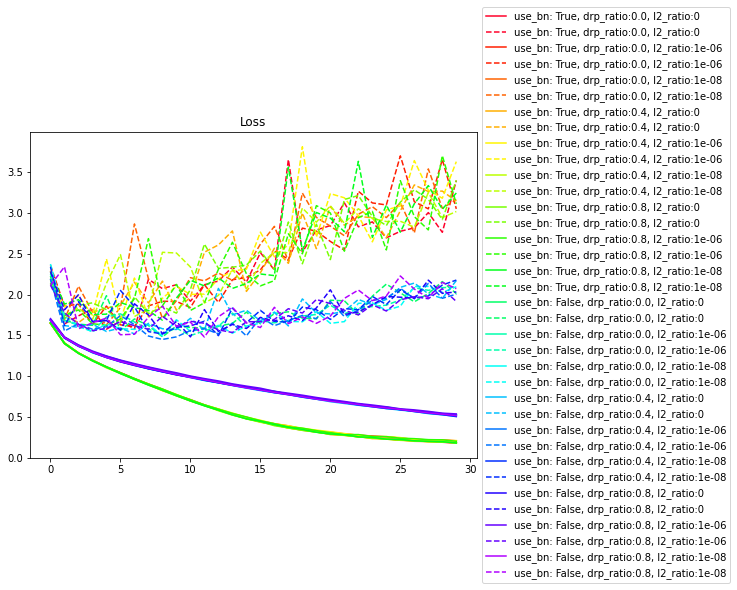

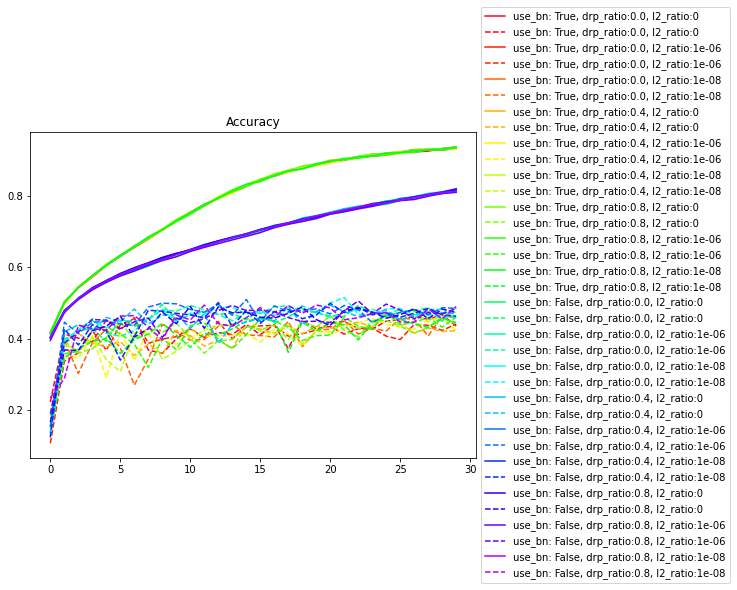

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()